# **Klasifikasi Sampah dengan Convolutional Neural Network (CNN)**
---

In [2]:
# File operations and data manipulation
import os, zipfile, shutil
from google.colab import drive
from shutil import copyfile

# Random number generation and numerical computations
import random
import numpy as np

# Visualization library
import matplotlib.pyplot as plt

# Deep learning framework and its modules
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Ignore warnings during execution
import warnings
warnings.filterwarnings("ignore")

# Print TensorFlow version
print(tf.__version__)

2.14.0


## **Dataset Collection**
---

In [3]:
!wget --no-check-certificate \
  https://github.com/mrgsrylm/KlasifikasiSampah/releases/download/v1.0.0/kategori_sampah.zip \
  -O kategori_sampah.zip

!unzip kategori_sampah.zip

Streaming output truncated to the last 5000 lines.
  inflating: kategori_sampah/anorganik/anorganik6407.jpg  
  inflating: kategori_sampah/anorganik/anorganik5687.jpg  
  inflating: kategori_sampah/anorganik/anorganik3924.jpg  
  inflating: kategori_sampah/anorganik/anorganik2258.jpg  
  inflating: kategori_sampah/anorganik/anorganik1777.jpg  
  inflating: kategori_sampah/anorganik/anorganik10618.jpg  
 extracting: kategori_sampah/anorganik/anorganik2716.jpg  
  inflating: kategori_sampah/anorganik/anorganik876.jpg  
  inflating: kategori_sampah/anorganik/anorganik1861.jpg  
  inflating: kategori_sampah/anorganik/anorganik2870.jpg  
  inflating: kategori_sampah/anorganik/anorganik537.jpg  
  inflating: kategori_sampah/anorganik/anorganik1309.jpg  
  inflating: kategori_sampah/anorganik/anorganik627.jpg  
  inflating: kategori_sampah/anorganik/anorganik5624.jpg  
  inflating: kategori_sampah/anorganik/anorganik7212.jpg  
  inflating: kategori_sampah/anorganik/anorganik6488.jpg  
  infla

## **Data Pre-Processing**
---

### Settings Hyperparameter
---

In [4]:
# Constants for data splitting (T:90,V:10), batch size, input size (image dimensions), number of epochs, and data sample size
SPLIT_SIZE = 0.9
BATCH_SIZE = 32
INPUT_SIZE = (150, 150)
EPOCH = 20
N = 16

### Training & Validation Directories
---

In [5]:
DATASET_DIR = "dataset"
categories_dir = ["TRAINING", "VALIDATION"]
subcategories_dir = ["organik", "anorganik"]

for category in categories_dir:
    category_dir = os.path.join(DATASET_DIR, category)
    os.makedirs(category_dir)
    for subcategory in subcategories_dir:
        os.makedirs(os.path.join(category_dir, subcategory))

def list_directories(root_path):
  for rootdir, dirs, files in os.walk(root_path):
    for subdir in dirs:
      print(os.path.join(rootdir, subdir))

list_directories(DATASET_DIR)

dataset/TRAINING
dataset/VALIDATION
dataset/TRAINING/anorganik
dataset/TRAINING/organik
dataset/VALIDATION/anorganik
dataset/VALIDATION/organik


### Splitting Dataset

In [6]:
# split_data function: This function splits data from the source directory into training and validation sets
def split_data(SOURCE, TRAIN, VALIDATION, SPLIT_SIZE):
    # Get a list of non-empty files in the source director
    files = [filename for filename in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, filename)) > 0]

    # Shuffle the list of files
    shuffle_set = random.sample(files, len(files))

    # Calculate the number of files for training and validation sets based on the split size
    training_len = int(len(files) * SPLIT_SIZE)
    validation_len = len(files) - training_len

    # Divide the shuffled files into training and validation sets
    training_set = shuffle_set[:training_len]
    validation_set = shuffle_set[-validation_len:]

    for filename in training_set:
        source = os.path.join(SOURCE, filename)
        destiny = os.path.join(TRAIN, filename)
        copyfile(source, destiny)

    for filename in validation_set:
        source = os.path.join(SOURCE, filename)
        destiny = os.path.join(VALIDATION, filename)
        copyfile(source, destiny)

ORGANIK_DATASOURCE = "kategori_sampah/organik"
ANORGANIK_DATASOURCE = "kategori_sampah/anorganik"

TRAIN_DIR = "dataset/TRAINING"
VALIDATION_DIR = "dataset/VALIDATION"

ORGANIC_TRAIN_DIR = os.path.join(TRAIN_DIR, "organik/")
ORGANIC_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "organik/")

RECYCLABLE_TRAIN_DIR = os.path.join(TRAIN_DIR, "anorganik/")
RECYCLABLE_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "anorganik/")

# Clear existing file
for directory in [ORGANIC_TRAIN_DIR, ORGANIC_VALIDATION_DIR, RECYCLABLE_TRAIN_DIR, RECYCLABLE_VALIDATION_DIR]:
    for file in os.scandir(directory):
        os.remove(file.path)

# Do splitting and move data
split_data(ORGANIK_DATASOURCE, ORGANIC_TRAIN_DIR, ORGANIC_VALIDATION_DIR, SPLIT_SIZE)
split_data(ANORGANIK_DATASOURCE, RECYCLABLE_TRAIN_DIR, RECYCLABLE_VALIDATION_DIR, SPLIT_SIZE)

# Print the number of files in each directory
print(f"\nThere are {len(os.listdir(ORGANIC_TRAIN_DIR))} organic material images in training")
print(f"There are {len(os.listdir(ORGANIC_VALIDATION_DIR))} organic material images in validation")
print(f"There are {len(os.listdir(RECYCLABLE_TRAIN_DIR))} recyclable material images in training")
print(f"There are {len(os.listdir(RECYCLABLE_VALIDATION_DIR))} recyclable material images in validation")


There are 12569 organic material images in training
There are 1397 organic material images in validation
There are 9999 recyclable material images in training
There are 1112 recyclable material images in validation


### Training Validation Generator and Data Augmentation
---

In [7]:
# train_val_generators function: This function creates and configures data generators for training and validation data.
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, BATCH_SIZE, INPUT_SIZE):

    # Training data augmentation configuration
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation data augmentation configuration
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Generating batches of augmented data for training
    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        target_size=INPUT_SIZE
    )

    # Generating batches of non-augmented data for validation
    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        target_size=INPUT_SIZE
    )

    # Return the configured data generators for training and validation
    return train_generator, validation_generator

# TRAIN AND VALIDATION GENERATOR
TRAIN_GENERATOR, VALIDATION_GENERATOR = train_val_generators(TRAIN_DIR, VALIDATION_DIR, BATCH_SIZE, INPUT_SIZE)


Found 22568 images belonging to 2 classes.
Found 2509 images belonging to 2 classes.


## **Model Simple CNN**
---

### **Model Definition**
---

#### Create Model using CNN and Implement Flatten, Dropout, and Regularization
---

In [ ]:
# create_model function: This function defines and compiles a convolutional neural network model.
def create_model_simple_cnn(INPUT_SHAPE, NUM_CLASSES):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')
    ])

    # Compile the model with appropriate optimizer, loss function, and metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create Model
INPUT_SHAPE = (150, 150, 3)
NUM_CLASSES = 2
model_simple_cnn = create_model_simple_cnn(INPUT_SHAPE, NUM_CLASSES)
model_simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### **Training**
---

In [ ]:
# Training the model using the training generator and validating it using the validation generator
# 'EPOCH' specifies the number of epochs for training
# The 'verbose' parameter is set to 1 for detailed progress output during training
history_simple_cnn = model_simple_cnn.fit(TRAIN_GENERATOR,
                    epochs=EPOCH,
                    validation_data=VALIDATION_GENERATOR,
                    verbose=1)

Epoch 1/20
706/706 [==============================] - 175s 228ms/step - loss: 0.4353 - accuracy: 0.8117 - val_loss: 0.3915 - val_accuracy: 0.8270
Epoch 2/20
706/706 [==============================] - 159s 225ms/step - loss: 0.3964 - accuracy: 0.8299 - val_loss: 0.3677 - val_accuracy: 0.8386
Epoch 3/20
706/706 [==============================] - 160s 226ms/step - loss: 0.3767 - accuracy: 0.8396 - val_loss: 0.3575 - val_accuracy: 0.8462
Epoch 4/20
706/706 [==============================] - 158s 223ms/step - loss: 0.3581 - accuracy: 0.8486 - val_loss: 0.3278 - val_accuracy: 0.8565
Epoch 5/20
706/706 [==============================] - 161s 227ms/step - loss: 0.3483 - accuracy: 0.8549 - val_loss: 0.3084 - val_accuracy: 0.8677
Epoch 6/20
706/706 [==============================] - 159s 226ms/step - loss: 0.3412 - accuracy: 0.8590 - val_loss: 0.3315 - val_accuracy: 0.8653
Epoch 7/20
706/706 [==============================] - 162s 229ms/step - loss: 0.3364 - accuracy: 0.8609 - val_loss: 0.3099 -

### **Evaluation**
---

#### Plotting Accuracy and Model Evaluation
---

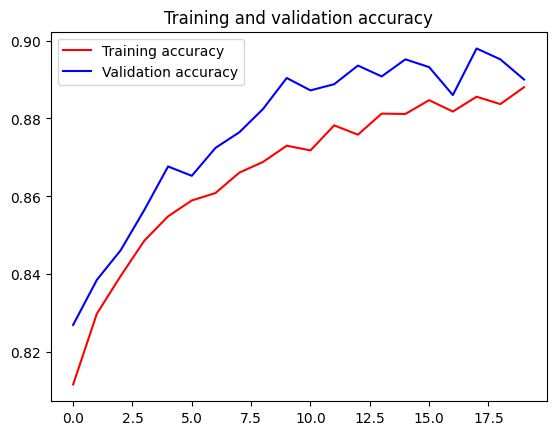

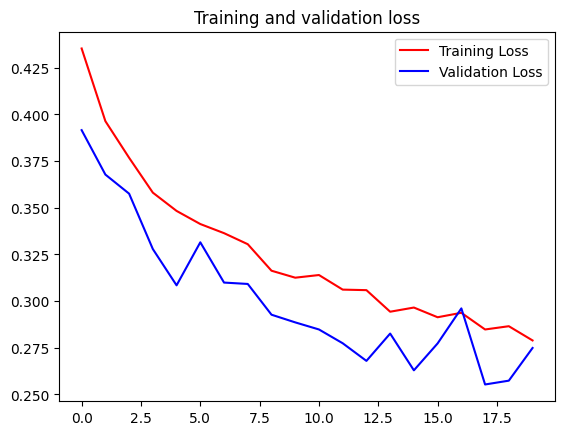

In [ ]:
acc = history_simple_cnn.history['accuracy']
val_acc = history_simple_cnn.history['val_accuracy']
loss = history_simple_cnn.history['loss']
val_loss = history_simple_cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
_, accuracy = model_simple_cnn.evaluate_generator(VALIDATION_GENERATOR, steps=10, verbose=0)

print('Test Accuracy: %.3f%%' % (accuracy * 100))


Test Accuracy: 87.813%


### **Test**
---

1/1 [==============================] - 0s 29ms/step
Predicted label for a_test: anorganik
Predicted label for o_test: organik


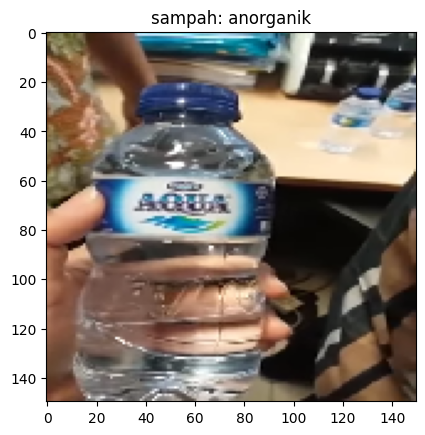

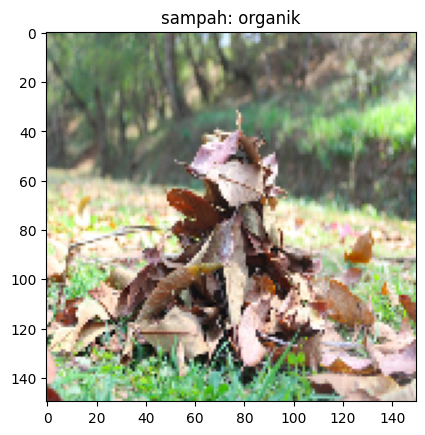

In [ ]:
# Extracting class labels and creating a dictionary for label decoding
labels = VALIDATION_GENERATOR.class_indices
labels = dict((v, k) for k, v in labels.items())
target_size = (150, 150)

# Load and preprocess images
a_test_path = 'kategori_sampah/test/sampah_botol_aqua.png'
a_test_image = image.load_img(a_test_path, target_size=target_size)
a_test = image.img_to_array(a_test_image)
a_test = np.expand_dims(a_test_image, axis = 0)

o_test_path = 'kategori_sampah/test/sampah_daun_kering.png'
o_test_image = image.load_img(o_test_path, target_size=target_size)
o_test = image.img_to_array(o_test_image)
o_test = np.expand_dims(o_test_image, axis = 0)

# Make predictions
a_result = model_simple_cnn.predict(a_test)
o_result = model_simple_cnn.predict(o_test)

# Decode and display predictions
a_predicted_label = labels[np.argmax(a_result[0])]
o_predicted_label = labels[np.argmax(o_result[0])]

print('Predicted label for a_test: %s' % a_predicted_label)
print('Predicted label for o_test: %s' % o_predicted_label)

# Display images
plt.title('sampah: %s' % a_predicted_label)
plt.imshow(a_test_image)
plt.show()

plt.title('sampah: %s' % o_predicted_label)
plt.imshow(o_test_image)
plt.show()

## **Model Inception CNN**
---

In [8]:
from keras.applications.inception_v3 import InceptionV3
from keras import layers
from keras import Model

### **Model Definition**
---

#### Create Model Inception using Transfer Learning
---

In [9]:
inception_pretrained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,  # Excluding the top (classification) layers
                                weights='imagenet')  # Using pre-trained weights from ImageNet

for layer in inception_pretrained_model.layers:
    layer.trainable = False

inception_pretrained_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [10]:
# Getting the output from a specific layer ('mixed6') of the pre-trained InceptionV3 model
last_layer = inception_pretrained_model.get_layer('mixed6')
print('Last layer output shape:', last_layer.output_shape)  # Printing the output shape of the selected layer
last_output = last_layer.output  # Storing the output tensor of the selected layer for further processing

Last layer output shape: (None, 7, 7, 768)


In [11]:
# Adding a Flatten layer to convert the 3D tensor to 1D vector
x = layers.Flatten()(last_output)

# Adding a Dense layer with 512 units and ReLU activation function
x = layers.Dense(512, activation='relu')(x)

# Applying Dropout with a dropout rate of 0.2 to prevent overfitting
x = layers.Dropout(0.2)(x)

# Adding the final Dense layer with 2 units (for binary classification) and sigmoid activation function
predictions = layers.Dense(2, activation='sigmoid')(x)

# Creating the custom model by specifying its input (pretrained InceptionV3 model's input) and output (predictions)
model_inception = Model(inception_pretrained_model.input, predictions)

In [12]:
# Compiling the InceptionV3-based model
model_inception.compile(optimizer=tf.keras.optimizers.Adam(0.0001),  # Using Adam optimizer with a learning rate of 0.0001
                        loss='binary_crossentropy',  # Binary crossentropy loss for binary classification task
                        metrics=['accuracy'])  # Monitoring accuracy as the evaluation metric

# Printing the summary of the compiled model architecture
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

### **Training**
---

In [13]:
# Training the model using the training generator and validating it using the validation generator
history_inception = model_inception.fit(TRAIN_GENERATOR,  # Training data generator
                                        epochs=EPOCH,  # Number of epochs for training
                                        validation_data=VALIDATION_GENERATOR,  # Validation data generator
                                        verbose=1)  # Setting verbosity level to 1 for detailed progress output during training


Epoch 1/20
706/706 [==============================] - 170s 222ms/step - loss: 0.2674 - accuracy: 0.8934 - val_loss: 0.2207 - val_accuracy: 0.9183
Epoch 2/20
706/706 [==============================] - 152s 216ms/step - loss: 0.2237 - accuracy: 0.9118 - val_loss: 0.2211 - val_accuracy: 0.9199
Epoch 3/20
706/706 [==============================] - 153s 217ms/step - loss: 0.2104 - accuracy: 0.9163 - val_loss: 0.2186 - val_accuracy: 0.9207
Epoch 4/20
706/706 [==============================] - 154s 218ms/step - loss: 0.1999 - accuracy: 0.9219 - val_loss: 0.2004 - val_accuracy: 0.9239
Epoch 5/20
706/706 [==============================] - 154s 218ms/step - loss: 0.1876 - accuracy: 0.9282 - val_loss: 0.1965 - val_accuracy: 0.9322
Epoch 6/20
706/706 [==============================] - 154s 218ms/step - loss: 0.1831 - accuracy: 0.9299 - val_loss: 0.2000 - val_accuracy: 0.9322
Epoch 7/20
706/706 [==============================] - 161s 229ms/step - loss: 0.1785 - accuracy: 0.9313 - val_loss: 0.2051 -

### **Evaluation**
---

#### Plotting Accuracy and Model Evaluation
---

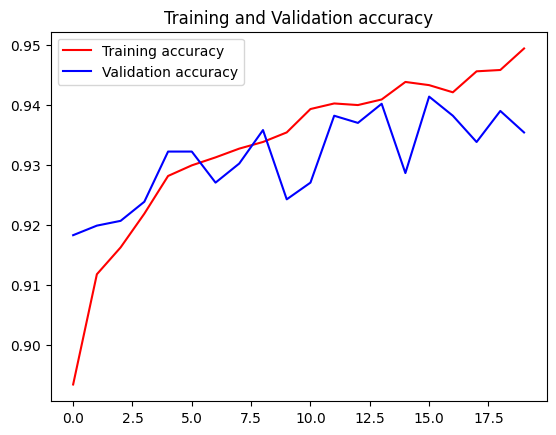

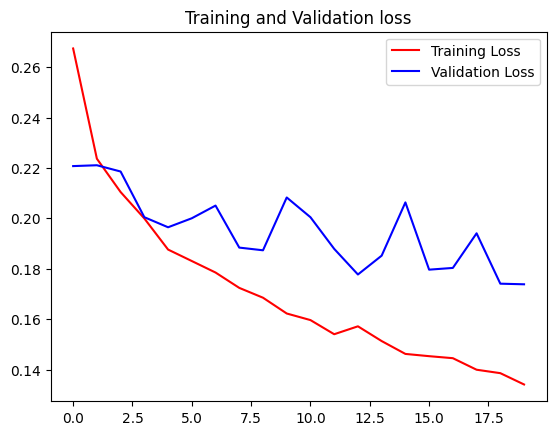

In [14]:
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [15]:
_, acc = model_inception.evaluate_generator(VALIDATION_GENERATOR, steps=10, verbose=0)
print('Test Accuracy: %.3f ' % (acc * 100))

Test Accuracy: 93.437 


### **Test**
---

1/1 [==============================] - 0s 22ms/step
Predicted label for a_test: organik
Predicted label for o_test: organik


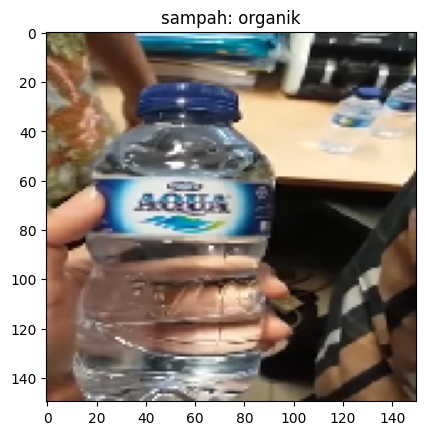

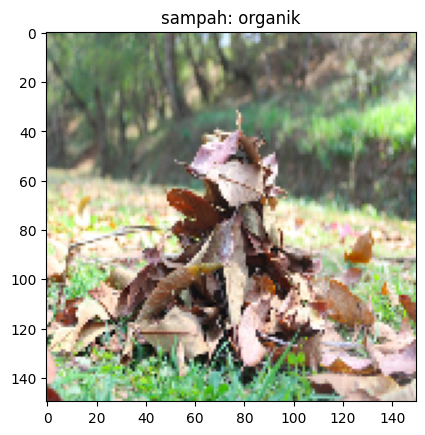

In [16]:
# Extracting class labels and creating a dictionary for label decoding
labels = VALIDATION_GENERATOR.class_indices
labels = dict((v, k) for k, v in labels.items())
target_size = (150, 150)

# Load and preprocess images
a_test_path = 'kategori_sampah/test/sampah_botol_aqua.png'
a_test_image = image.load_img(a_test_path, target_size=target_size)
a_test = image.img_to_array(a_test_image)
a_test = np.expand_dims(a_test_image, axis = 0)

o_test_path = 'kategori_sampah/test/sampah_daun_kering.png'
o_test_image = image.load_img(o_test_path, target_size=target_size)
o_test = image.img_to_array(o_test_image)
o_test = np.expand_dims(o_test_image, axis = 0)

# Make predictions
a_result = model_inception.predict(a_test)
o_result = model_inception.predict(o_test)

# Decode and display predictions
a_predicted_label = labels[np.argmax(a_result[0])]
o_predicted_label = labels[np.argmax(o_result[0])]

print('Predicted label for a_test: %s' % a_predicted_label)
print('Predicted label for o_test: %s' % o_predicted_label)

# Display images
plt.title('sampah: %s' % a_predicted_label)
plt.imshow(a_test_image)
plt.show()

plt.title('sampah: %s' % o_predicted_label)
plt.imshow(o_test_image)
plt.show()

### **Store Model**
---

#### Save Model (h5)
---

In [17]:
!mkdir -p "saved_model_inception"
!mkdir -p "tflite_model_inception"
model_inception.save('saved_model_inception/model_class_inceptionv3.h5')

#### Convert to TFLite
---

In [18]:
tf.saved_model.save(model_inception, export_dir="saved_model_inception")

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_inception")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_inception = converter.convert()

In [19]:
import pathlib
tflite_model_file = pathlib.Path("tflite_model_inception/model_class_inveptionv3.tflite")
tflite_model_file.write_bytes(tflite_model_inception)

26236152

## **Model Xception CNN**
---

In [20]:
from keras.applications.xception import Xception
from keras import layers
from keras import Model

### **Model Definition**
---

#### Create Model using Transfer Learning
---

In [21]:
xception_pretrained_model = Xception(input_shape = (150, 150, 3),
                                     include_top = False,
                                     weights = "imagenet")

83683744/83683744 [==============================] - 0s 0us/step


In [22]:
for layer in xception_pretrained_model.layers:
  layer.trainable = False

xception_pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [23]:
last_layer = xception_pretrained_model.get_layer('add_11')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1024)


In [24]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2, activation='sigmoid')(x)
model_xception = Model(xception_pretrained_model.input, x)

In [25]:
model_xception.compile(optimizer=tf.optimizers.Adam(0.0001),
                       loss="binary_crossentropy",
                       metrics=["accuracy"])
model_xception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]'

### **Training**
---

In [26]:
history_xception = model_xception.fit(TRAIN_GENERATOR,
                                      epochs = EPOCH,
                                      validation_data = VALIDATION_GENERATOR,
                                      verbose = 1)

Epoch 1/20
706/706 [==============================] - 176s 245ms/step - loss: 0.2724 - accuracy: 0.8999 - val_loss: 0.2089 - val_accuracy: 0.9279
Epoch 2/20
706/706 [==============================] - 166s 234ms/step - loss: 0.2023 - accuracy: 0.9230 - val_loss: 0.1943 - val_accuracy: 0.9295
Epoch 3/20
706/706 [==============================] - 166s 235ms/step - loss: 0.1898 - accuracy: 0.9275 - val_loss: 0.1861 - val_accuracy: 0.9338
Epoch 4/20
706/706 [==============================] - 165s 234ms/step - loss: 0.1832 - accuracy: 0.9292 - val_loss: 0.1944 - val_accuracy: 0.9346
Epoch 5/20
706/706 [==============================] - 167s 237ms/step - loss: 0.1716 - accuracy: 0.9330 - val_loss: 0.2075 - val_accuracy: 0.9275
Epoch 6/20
706/706 [==============================] - 165s 233ms/step - loss: 0.1639 - accuracy: 0.9373 - val_loss: 0.2000 - val_accuracy: 0.9263
Epoch 7/20
706/706 [==============================] - 166s 235ms/step - loss: 0.1604 - accuracy: 0.9377 - val_loss: 0.1830 -

### **Evaluation**
---

#### Plotting Accuracy and Model Evaluation
---

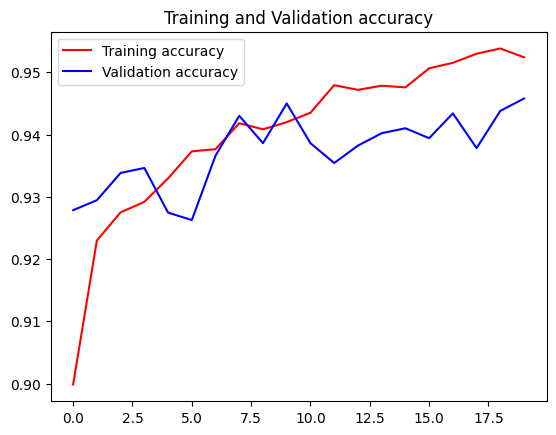

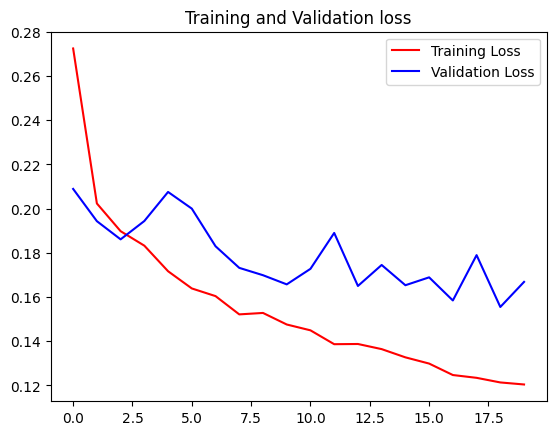

In [27]:
acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [28]:
_, acc = model_xception.evaluate_generator(VALIDATION_GENERATOR, steps=10, verbose=0)
print('Test Accuracy: %.3f ' % (acc * 100))

Test Accuracy: 95.312 


### **Test**
---

1/1 [==============================] - 0s 105ms/step
Predicted label for a_test: organik
Predicted label for o_test: anorganik


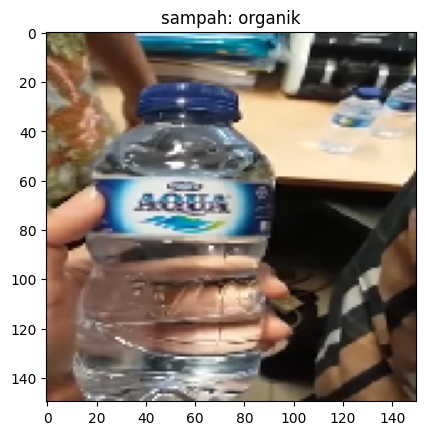

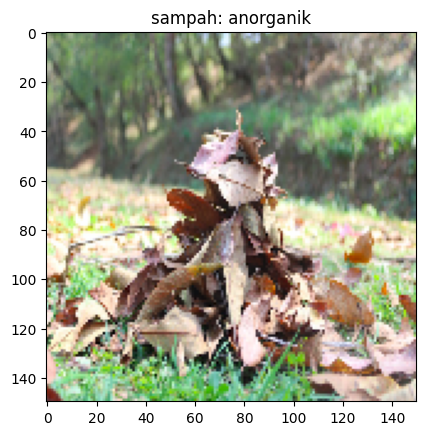

In [29]:
# Extracting class labels and creating a dictionary for label decoding
labels = VALIDATION_GENERATOR.class_indices
labels = dict((v, k) for k, v in labels.items())
target_size = (150, 150)

# Load and preprocess images
a_test_path = 'kategori_sampah/test/sampah_botol_aqua.png'
a_test_image = image.load_img(a_test_path, target_size=target_size)
a_test = image.img_to_array(a_test_image)
a_test = np.expand_dims(a_test_image, axis = 0)

o_test_path = 'kategori_sampah/test/sampah_daun_kering.png'
o_test_image = image.load_img(o_test_path, target_size=target_size)
o_test = image.img_to_array(o_test_image)
o_test = np.expand_dims(o_test_image, axis = 0)

# Make predictions
a_result = model_xception.predict(a_test)
o_result = model_xception.predict(o_test)

# Decode and display predictions
a_predicted_label = labels[np.argmax(a_result[0])]
o_predicted_label = labels[np.argmax(o_result[0])]

print('Predicted label for a_test: %s' % a_predicted_label)
print('Predicted label for o_test: %s' % o_predicted_label)

# Display images
plt.title('sampah: %s' % a_predicted_label)
plt.imshow(a_test_image)
plt.show()

plt.title('sampah: %s' % o_predicted_label)
plt.imshow(o_test_image)
plt.show()

### **Store Model**
---

In [30]:
!mkdir saved_model_xception
!mkdir tflite_model_xception

#### Save Model (h5)
---

In [31]:
saved_model_path = "saved_model_xception/model_class_best.h5"
model_xception.save(saved_model_path)

#### Convert to TFLite
---

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_xception)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_xception = converter.convert()

In [33]:
import pathlib


tflite_model_file = pathlib.Path('tflite_model_xception/model_class_best.tflite')
tflite_model_file.write_bytes(tflite_model_xception)
print("Model successfully created in .tflite!")

Model successfully created in .tflite!


## Save Model to Google Drive
---

In [34]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [35]:
# Model Inception
source_saved_model_inception = "/content/saved_model_inception"
destination_saved_model_inception = "/content/drive/My Drive/klasifikasi_sampah/class/saved_model_inception"
shutil.copytree(source_saved_model_inception, destination_saved_model_inception)

source_tflite_model_inception = "/content/tflite_model_inception"
destination_tflite_model_inception = "/content/drive/My Drive/klasifikasi_sampah/class/tflite_model_inception"
shutil.copytree(source_tflite_model_inception, destination_tflite_model_inception)

'/content/drive/My Drive/klasifikasi_sampah/class/tflite_model_inception'

In [36]:
# Xception
source_saved_model_xception = "/content/saved_model_xception"
destination_saved_model_xception = "/content/drive/My Drive/klasifikasi_sampah/class/saved_model_xception"
shutil.copytree(source_saved_model_xception, destination_saved_model_xception)

source_tflite_model_xception = "/content/tflite_model_xception"
destination_tflite_model_xception = "/content/drive/My Drive/klasifikasi_sampah/class/tflite_model_xception"
shutil.copytree(source_tflite_model_xception, destination_tflite_model_xception)

'/content/drive/My Drive/klasifikasi_sampah/class/tflite_model_xception'